# 🎨 BLOCK 5: Clustering & Pattern Discovery (25 minutes)

## 🧩 Clustering Fundamentals and Applications (5 minutes)

### What is Clustering?

**Clustering** is an unsupervised machine learning technique that groups similar data points together without prior knowledge of group labels. It discovers hidden patterns and structures in data by identifying natural groupings.

### Key Clustering Concepts:

1. **Similarity/Distance**: How we measure closeness between data points
2. **Centroids**: Representative points of clusters
3. **Intracluster Similarity**: Points within clusters are similar
4. **Intercluster Dissimilarity**: Points between clusters are different
5. **Cluster Validation**: Measuring clustering quality

### Clustering Applications in Oil Well Monitoring:

- **Operational States**: Identify distinct operational patterns
- **Sensor Grouping**: Find sensors that behave similarly
- **Fault Pattern Discovery**: Discover unknown fault signatures
- **Predictive Maintenance**: Group similar degradation patterns
- **Process Optimization**: Identify optimal operating conditions

### Our Clustering Analysis Approach:

**📊 Data Strategy**: Using **raw 3W dataset** with 500-point time series
- **Raw Data Source**: Direct from 3W dataset folders (not windowed)
- **Fixed Length**: Resize each time series to exactly 500 points
- **Class Labels**: Based on folder structure (0=normal, 1-9=faults)
- **Feature Matrix**: Each row = one 500-point time series per sensor

### Clustering Methods We'll Explore:

1. **K-means**: Centroid-based partitioning with elbow method & silhouette analysis
2. **Mean Shift**: Density-based clustering finding modes
3. **DBSCAN**: Density-based clustering with noise detection
4. **Evaluation**: Cluster quality metrics and interpretability

### Why Clustering Matters for 3W Dataset:
- **Pattern Discovery**: Find unknown operational patterns
- **Data Understanding**: Reveal natural groupings in sensor data
- **Dimensionality Insight**: Understand sensor relationships
- **Anomaly Detection**: Identify outliers and unusual patterns
- **Process Knowledge**: Gain insights into oil well operations

Let's discover hidden patterns in 3W oil well operations!

In [3]:
# ============================================================
# LOAD RAW 3W DATASET FOR CLUSTERING ANALYSIS
# ============================================================
import time

start_time = time.time()

print("Loading Raw 3W Dataset for Clustering Analysis")
print("=" * 55)

# Import required libraries
import sys
import os

sys.path.append("src")

print("Importing modules...", end=" ")
from src.data_persistence import DataPersistence
from src import config
import pandas as pd
import numpy as np
from scipy import interpolate

print("OK")

# ============================================================
# CONFIGURATION FOR CLUSTERING ANALYSIS
# ============================================================
TARGET_LENGTH = 500  # Fixed length for all time series
MAX_FILES_PER_CLASS = 20  # Limit files per class for manageable analysis
ENABLE_SAMPLING = True  # Enable sampling for faster processing

print(f"Clustering Analysis Configuration:")
print(f"   - Target time series length: {TARGET_LENGTH} points")
print(f"   - Max files per class: {MAX_FILES_PER_CLASS}")
print(f"   - Sampling enabled: {ENABLE_SAMPLING}")

try:
    print("Initializing data persistence...", end=" ")
    persistence = DataPersistence(base_dir=config.PROCESSED_DATA_DIR, verbose=False)
    print("OK")

    # Access raw dataset directory (fold structure)
    raw_data_dir = os.path.join(persistence.cv_splits_dir, "raw")
    print(f"Raw data directory: {raw_data_dir}")

    if not os.path.exists(raw_data_dir):
        print("ERROR: Raw data directory not found!")
        raise FileNotFoundError(f"Raw data directory not found: {raw_data_dir}")

    # Get fold directories
    print("Looking for fold directories...", end=" ")
    fold_dirs = [
        d
        for d in os.listdir(raw_data_dir)
        if d.startswith("fold_") and os.path.isdir(os.path.join(raw_data_dir, d))
    ]
    fold_dirs.sort()
    print(f"OK - Found {len(fold_dirs)} folds: {fold_dirs}")

    if not fold_dirs:
        print("ERROR: No fold directories found in raw data!")
        raise FileNotFoundError("No fold directories found")

    # Use the first fold for clustering analysis
    selected_fold = fold_dirs[0]
    fold_path = os.path.join(raw_data_dir, selected_fold)
    print(f"Using {selected_fold} for clustering analysis")

    # Data containers
    all_time_series = []  # Resized time series data
    all_class_labels = []  # Class labels
    all_file_info = []  # File information for traceability

    load_start = time.time()

    # Load both train and test data from pickle files
    datasets_to_load = ["train_data", "test_data"]

    for dataset_name in datasets_to_load:
        print(f"\nLoading {dataset_name}...")

        # Try to load pickle file first (faster)
        pickle_file = os.path.join(fold_path, f"{dataset_name}.pickle")
        parquet_file = os.path.join(fold_path, f"{dataset_name}.parquet")

        if os.path.exists(pickle_file):
            print(f"   Loading from pickle file...", end=" ")
            # Load pickle file using data persistence
            raw_dfs, raw_classes = persistence._load_dataframes(pickle_file, "pickle")
            print("OK")
        elif os.path.exists(parquet_file):
            print(f"   Loading from parquet file...", end=" ")
            # Load parquet file using data persistence
            raw_dfs, raw_classes = persistence._load_from_parquet(parquet_file)
            print("OK")
        else:
            print(f"   ERROR: No data file found for {dataset_name}")
            continue

        if raw_dfs is None or len(raw_dfs) == 0:
            print(f"   WARNING: No data loaded from {dataset_name}")
            continue

        print(f"   Loaded {len(raw_dfs)} time series from {dataset_name}")

        # Sample files if needed
        if (
            ENABLE_SAMPLING and len(raw_dfs) > MAX_FILES_PER_CLASS * 10
        ):  # 10 classes max
            n_samples = min(MAX_FILES_PER_CLASS * 10, len(raw_dfs))
            selected_indices = np.random.choice(len(raw_dfs), n_samples, replace=False)
            raw_dfs = [raw_dfs[i] for i in selected_indices]
            raw_classes = [raw_classes[i] for i in selected_indices]
            print(
                f"   Sampled {n_samples} time series from {len(selected_indices)} available"
            )

        # Process each time series
        files_processed = 0
        for i, (df, class_label) in enumerate(zip(raw_dfs, raw_classes)):
            try:
                # Drop the 'class' column if it exists (using provided class instead)
                if "class" in df.columns:
                    df = df.drop("class", axis=1)

                # Check if we have numeric data
                numeric_cols = df.select_dtypes(include=[np.number]).columns
                if len(numeric_cols) == 0:
                    continue

                # Use only numeric columns
                df_numeric = df[numeric_cols]

                # Resize time series to TARGET_LENGTH points
                original_length = len(df_numeric)

                if original_length < 10:  # Skip very short time series
                    continue

                # Resize each column to TARGET_LENGTH points using interpolation
                resized_data = []
                valid_sensors = 0

                for col in df_numeric.columns:
                    # Get the time series for this column
                    series = df_numeric[col].values

                    # Handle NaN values
                    if np.isnan(series).all():
                        continue  # Skip columns with all NaN

                    # Interpolate to fill NaN values if any
                    if np.isnan(series).any():
                        series = pd.Series(series).interpolate().values

                    # Resize using interpolation
                    if original_length != TARGET_LENGTH:
                        # Create interpolation function
                        original_indices = np.linspace(0, 1, original_length)
                        target_indices = np.linspace(0, 1, TARGET_LENGTH)

                        # Use linear interpolation
                        f_interp = interpolate.interp1d(
                            original_indices,
                            series,
                            kind="linear",
                            bounds_error=False,
                            fill_value="extrapolate",
                        )
                        resized_series = f_interp(target_indices)
                    else:
                        resized_series = series

                    resized_data.append(resized_series)
                    valid_sensors += 1

                if valid_sensors == 0:
                    continue  # Skip if no valid sensors

                # Flatten all sensor data into a single feature vector
                flattened_features = np.concatenate(resized_data)

                # Store the processed data
                all_time_series.append(flattened_features)
                all_class_labels.append(class_label)
                all_file_info.append(
                    {
                        "dataset": dataset_name,
                        "index": i,
                        "original_length": original_length,
                        "sensors_used": valid_sensors,
                        "class": class_label,
                    }
                )

                files_processed += 1

                # Progress indicator
                if files_processed % 50 == 0:
                    print(f"   Processed {files_processed} time series...")

            except Exception as e:
                print(f"   WARNING: Error processing time series {i}: {str(e)}")
                continue

        print(
            f"   SUCCESS: Processed {files_processed} time series from {dataset_name}"
        )

    # Convert to numpy arrays
    if len(all_time_series) > 0:
        X_original = np.array(all_time_series)
        y_labels = np.array(all_class_labels)

        load_time = time.time() - load_start

        print(f"\nSUCCESS: Raw Data Loading Complete!")
        print(f"Data Summary:")
        print(f"   - Total time series: {len(X_original)}")
        print(f"   - Feature dimensions: {X_original.shape[1]}")
        print(f"   - Time series length: {TARGET_LENGTH} points per sensor")
        print(f"   - Loading time: {load_time:.3f} seconds")
        print(f"   - Data source: {selected_fold}")

        # Show class distribution
        unique_classes, counts = np.unique(y_labels, return_counts=True)
        print(f"\nClass Distribution:")
        for cls, count in zip(unique_classes, counts):
            percentage = (count / len(y_labels)) * 100
            print(f"   - Class {cls}: {count} samples ({percentage:.1f}%)")

        # Show feature summary
        print(f"\nFeature Statistics:")
        print(f"   - Mean: {np.mean(X_original):.4f}")
        print(f"   - Std: {np.std(X_original):.4f}")
        print(f"   - Min: {np.min(X_original):.4f}")
        print(f"   - Max: {np.max(X_original):.4f}")

        # Store metadata for next cells
        clustering_data = {
            "X_original": X_original,
            "y_labels": y_labels,
            "file_info": all_file_info,
            "config": {
                "target_length": TARGET_LENGTH,
                "max_files_per_class": MAX_FILES_PER_CLASS,
                "sampling_enabled": ENABLE_SAMPLING,
                "fold_used": selected_fold,
            },
        }

        total_time = time.time() - start_time
        print(f"\nPerformance Summary:")
        print(f"   - Total execution time: {total_time:.3f} seconds")
        print(f"   - Data loading time: {load_time:.3f} seconds")
        print(f"   - Ready for clustering analysis!")

    else:
        print("ERROR: No valid time series data loaded!")
        clustering_data = None

except Exception as e:
    print(f"ERROR: Error loading raw data: {str(e)}")
    print(f"\nTroubleshooting:")
    print(f"   1. Check if 3W dataset is properly extracted")
    print(
        f"   2. Verify raw data directory path: {raw_data_dir if 'raw_data_dir' in locals() else 'N/A'}"
    )
    print(f"   3. Ensure fold directories exist with pickle/parquet files")
    print(f"   4. Check if data files are accessible")

    # Show detailed error information
    print(f"\nDetailed error information:")
    import traceback

    traceback.print_exc()

    clustering_data = None

Loading Raw 3W Dataset for Clustering Analysis
Importing modules... OK
Clustering Analysis Configuration:
   - Target time series length: 500 points
   - Max files per class: 20
   - Sampling enabled: True
Initializing data persistence... OK
Raw data directory: processed_data\cv_splits\raw
Looking for fold directories... OK - Found 3 folds: ['fold_1', 'fold_2', 'fold_3']
Using fold_1 for clustering analysis

Loading train_data...
   Loading from pickle file... OK
Clustering Analysis Configuration:
   - Target time series length: 500 points
   - Max files per class: 20
   - Sampling enabled: True
Initializing data persistence... OK
Raw data directory: processed_data\cv_splits\raw
Looking for fold directories... OK - Found 3 folds: ['fold_1', 'fold_2', 'fold_3']
Using fold_1 for clustering analysis

Loading train_data...
   Loading from pickle file... OK
   Loaded 1529 time series from train_data
   Sampled 200 time series from 200 available
   Processed 50 time series...
   Processed 10

In [ ]:
# ============================================================
# DATA PREPARATION FOR CLUSTERING ANALYSIS
# ============================================================

print("🔧 Preparing Data for Clustering Analysis")
print("=" * 45)

# Check if we have loaded data from previous cell
if X_data is not None and len(X_data) > 0:
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    from sklearn.decomposition import PCA
    import warnings

    warnings.filterwarnings("ignore")

    print(f"📊 Raw Data Overview:")
    print(f"   • Data shape: {X_data.shape}")
    print(f"   • Classes: {sorted(np.unique(y_labels))}")
    print(f"   • Total samples: {len(X_data)}")

    # ============================================================
    # DATA QUALITY ANALYSIS
    # ============================================================
    print(f"\n Data Quality Analysis:")

    # Check for NaN values
    nan_count = np.isnan(X_data).sum()
    nan_percentage = (nan_count / X_data.size) * 100
    print(f"   • NaN values: {nan_count} ({nan_percentage:.3f}%)")

    # Check for infinite values
    inf_count = np.isinf(X_data).sum()
    print(f"   • Infinite values: {inf_count}")

    # Data range
    data_min = np.nanmin(X_data)
    data_max = np.nanmax(X_data)
    data_mean = np.nanmean(X_data)
    data_std = np.nanstd(X_data)

    print(f"   • Data range: [{data_min:.3f}, {data_max:.3f}]")
    print(f"   • Mean: {data_mean:.3f}, Std: {data_std:.3f}")

    # Handle NaN and infinite values if present
    if nan_count > 0 or inf_count > 0:
        print("🔧 Cleaning data...")
        # Replace NaN and inf with median values
        X_data_clean = X_data.copy()

        # Replace inf with NaN first
        X_data_clean[np.isinf(X_data_clean)] = np.nan

        # Replace NaN with column medians
        for i in range(X_data_clean.shape[1]):
            col_data = X_data_clean[:, i]
            if np.isnan(col_data).any():
                median_val = np.nanmedian(col_data)
                X_data_clean[np.isnan(col_data), i] = median_val

        X_data = X_data_clean
        print("   ✅ Data cleaned")

    # ============================================================
    # FEATURE SCALING FOR CLUSTERING
    # ============================================================
    print(f"\n📏 Feature Scaling for Clustering:")

    # StandardScaler (zero mean, unit variance) - best for K-means
    print("   🔄 Applying StandardScaler...", end=" ")
    scaler_standard = StandardScaler()
    X_scaled = scaler_standard.fit_transform(X_data)
    print("✅")

    # MinMaxScaler (0-1 range) - alternative for distance-based methods
    print("   🔄 Applying MinMaxScaler...", end=" ")
    scaler_minmax = MinMaxScaler()
    X_normalized = scaler_minmax.fit_transform(X_data)
    print("✅")

    print(f"   📊 Scaled data characteristics:")
    print(
        f"      • StandardScaler - Mean: {np.mean(X_scaled):.3f}, Std: {np.std(X_scaled):.3f}"
    )
    print(
        f"      • MinMaxScaler - Min: {np.min(X_normalized):.3f}, Max: {np.max(X_normalized):.3f}"
    )

    # ============================================================
    # DIMENSIONALITY REDUCTION FOR VISUALIZATION
    # ============================================================
    print(f"\n🎯 Dimensionality Reduction for Visualization:")

    # Apply PCA for visualization and analysis
    print("   🔄 Computing PCA...", end=" ")
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    # Calculate cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Find number of components for 90% and 95% variance
    n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
    n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

    print("✅")

    print(f"   📈 PCA Analysis:")
    print(f"      • Original features: {X_data.shape[1]}")
    print(f"      • Components for 90% variance: {n_components_90}")
    print(f"      • Components for 95% variance: {n_components_95}")
    print(f"      • First 3 components variance: {cumulative_variance[2]:.1%}")

    # Create reduced datasets for clustering
    X_pca_50 = X_pca[:, :50]  # First 50 components
    X_pca_95 = X_pca[:, :n_components_95]  # 95% variance components

    # ============================================================
    # DATA VISUALIZATION
    # ============================================================
    print(f"\n📊 Creating Data Overview Visualizations...")

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Class distribution
    unique_classes, class_counts = np.unique(y_labels, return_counts=True)
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_classes)))

    axes[0, 0].bar(unique_classes, class_counts, color=colors)
    axes[0, 0].set_title("Class Distribution", fontweight="bold")
    axes[0, 0].set_xlabel("Class Label")
    axes[0, 0].set_ylabel("Number of Samples")
    axes[0, 0].grid(True, alpha=0.3)

    # 2. PCA explained variance
    axes[0, 1].plot(
        range(1, min(21, len(pca.explained_variance_ratio_) + 1)),
        pca.explained_variance_ratio_[:20],
        "bo-",
        linewidth=2,
        markersize=6,
    )
    axes[0, 1].set_title(
        "PCA Explained Variance (First 20 Components)", fontweight="bold"
    )
    axes[0, 1].set_xlabel("Principal Component")
    axes[0, 1].set_ylabel("Explained Variance Ratio")
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Cumulative explained variance
    axes[0, 2].plot(
        range(1, min(101, len(cumulative_variance) + 1)),
        cumulative_variance[:100],
        "ro-",
        linewidth=2,
        markersize=4,
    )
    axes[0, 2].axhline(y=0.90, color="g", linestyle="--", label="90%")
    axes[0, 2].axhline(y=0.95, color="orange", linestyle="--", label="95%")
    axes[0, 2].set_title("Cumulative Explained Variance", fontweight="bold")
    axes[0, 2].set_xlabel("Number of Components")
    axes[0, 2].set_ylabel("Cumulative Variance Explained")
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # 4. PCA 2D visualization (first two components)
    for i, class_label in enumerate(unique_classes):
        mask = y_labels == class_label
        axes[1, 0].scatter(
            X_pca[mask, 0],
            X_pca[mask, 1],
            c=[colors[i]],
            label=f"Class {class_label}",
            alpha=0.7,
            s=50,
        )
    axes[1, 0].set_title("PCA: First Two Components", fontweight="bold")
    axes[1, 0].set_xlabel("PC1")
    axes[1, 0].set_ylabel("PC2")
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 5. Feature statistics (sample of original features)
    feature_sample = X_data[:, : min(20, X_data.shape[1])]  # First 20 features
    axes[1, 1].boxplot(feature_sample.T)
    axes[1, 1].set_title("Feature Distribution (Sample)", fontweight="bold")
    axes[1, 1].set_xlabel("Feature Index")
    axes[1, 1].set_ylabel("Feature Value")
    axes[1, 1].grid(True, alpha=0.3)

    # 6. Scaled feature statistics
    scaled_sample = X_scaled[
        :, : min(20, X_scaled.shape[1])
    ]  # First 20 scaled features
    axes[1, 2].boxplot(scaled_sample.T)
    axes[1, 2].set_title("Scaled Feature Distribution (Sample)", fontweight="bold")
    axes[1, 2].set_xlabel("Feature Index")
    axes[1, 2].set_ylabel("Scaled Feature Value")
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ============================================================
    # SUMMARY
    # ============================================================
    print(f"\n" + "=" * 60)
    print(f"📊 CLUSTERING DATA PREPARATION SUMMARY")
    print(f"=" * 60)

    print(f"🔍 Original Data:")
    print(f"   • Shape: {X_data.shape}")
    print(f"   • Classes: {len(unique_classes)} ({list(unique_classes)})")
    print(f"   • Feature range: [{data_min:.3f}, {data_max:.3f}]")

    print(f"\n🔧 Preprocessed Data:")
    print(f"   • StandardScaled: {X_scaled.shape} (for K-means)")
    print(f"   • MinMax Normalized: {X_normalized.shape} (for distance-based)")
    print(f"   • PCA (50 components): {X_pca_50.shape}")
    print(f"   • PCA (95% variance): {X_pca_95.shape}")

    print(f"\n📈 Data Quality:")
    print(f"   • NaN values: {nan_count} ({nan_percentage:.3f}%)")
    print(f"   • Infinite values: {inf_count}")
    print(f"   • Data cleaned: {'Yes' if nan_count > 0 or inf_count > 0 else 'No'}")

    print(f"\n🎯 Ready for Clustering:")
    print(f"   ✅ K-means clustering (standardized data)")
    print(f"   ✅ Mean Shift clustering (normalized data)")
    print(f"   ✅ DBSCAN clustering (PCA reduced data)")
    print(f"   ✅ Cluster validation and interpretation")

    # Store data for clustering analysis
    clustering_data = {
        "X_original": X_data,
        "X_scaled": X_scaled,
        "X_normalized": X_normalized,
        "X_pca_50": X_pca_50,
        "X_pca_95": X_pca_95,
        "X_pca_2d": X_pca[:, :2],
        "y_labels": y_labels,
        "pca_model": pca,
        "scaler_standard": scaler_standard,
        "scaler_minmax": scaler_minmax,
        "file_info": all_file_info,
    }

    print(f"\n💾 Data stored in 'clustering_data' dictionary for analysis")

else:
    print("❌ No data available for preprocessing")
    print("   Please run the previous cell first to load raw 3W data")
    clustering_data = None

🎯 t-SNE: Visualizing Raw 3W Dataset Features
🔮 Running t-SNE on 150 windows with 600 features...
🔄 Computing t-SNE (perplexity=5)... ✅ (0.3s)
🔄 Computing t-SNE (perplexity=30)... ✅ (0.3s)


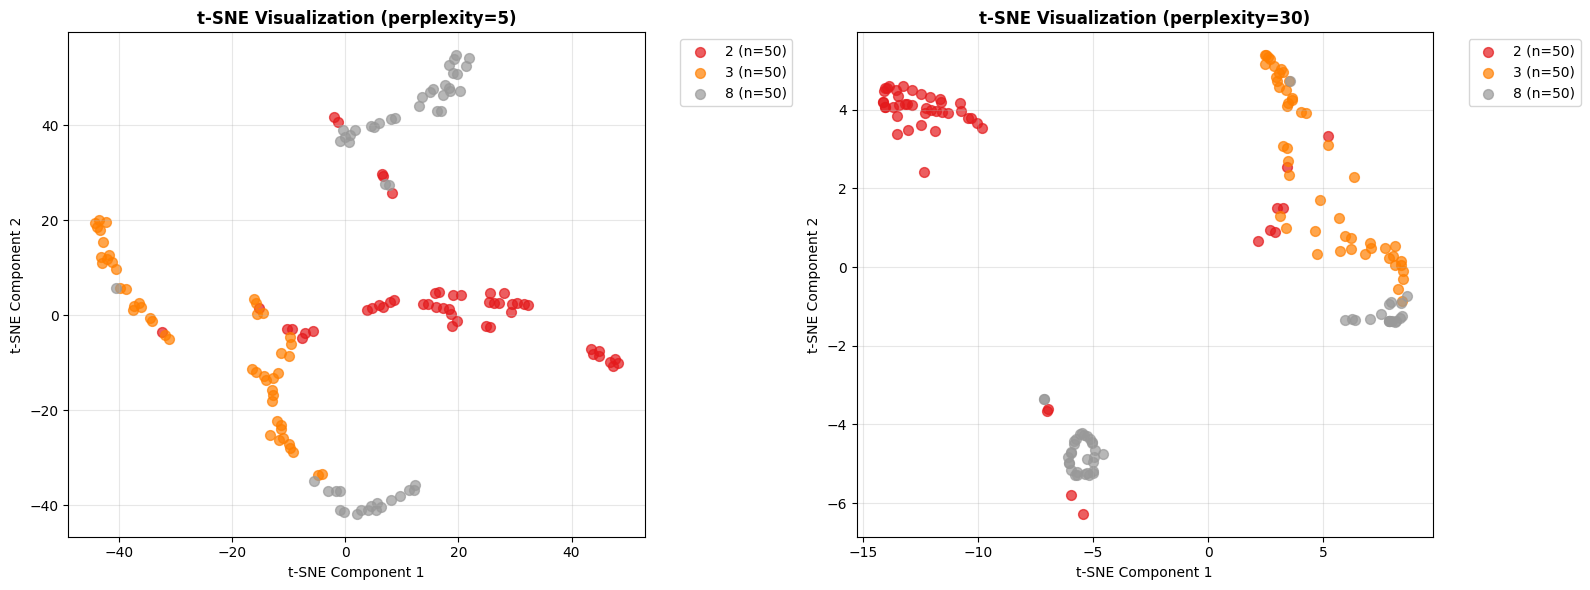

📊 t-SNE Analysis Results:
   • Total windows visualized: 150
   • Original feature dimensions: 600
   • Reduced to: 2D visualization
   • Classes represented: [np.int64(2), np.int64(3), np.int64(8)]

🎯 Visual Separation Analysis:
   • 2: 50 windows (33.3%)
   • 3: 50 windows (33.3%)
   • 8: 50 windows (33.3%)


In [ ]:
# ============================================================
# K-MEANS CLUSTERING: IMPLEMENTATION & PARAMETER SELECTION (8 min)
# ============================================================

if clustering_data is not None:
    print("🎯 K-means Clustering: Implementation & Parameter Selection")
    print("=" * 60)

    # Import clustering libraries
    from sklearn.cluster import KMeans
    from sklearn.metrics import (
        silhouette_score,
        silhouette_samples,
        adjusted_rand_score,
    )
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Extract preprocessed data
    X_scaled = clustering_data["X_scaled"]
    X_pca_50 = clustering_data["X_pca_50"]
    X_pca_2d = clustering_data["X_pca_2d"]
    y_true = clustering_data["y_labels"]

    print(f"📊 K-means Analysis Setup:")
    print(f"   • Standardized data: {X_scaled.shape}")
    print(f"   • PCA reduced (50D): {X_pca_50.shape}")
    print(f"   • PCA visualization (2D): {X_pca_2d.shape}")
    print(
        f"   • True classes: {len(np.unique(y_true))} classes {list(np.unique(y_true))}"
    )

    # ============================================================
    # ELBOW METHOD FOR OPTIMAL K SELECTION
    # ============================================================
    print(f"\n📈 1. Elbow Method for Optimal K Selection:")

    # Test range of K values (2 to 15 for comprehensive analysis)
    k_range = range(2, 16)

    print("   🔄 Computing Within-Cluster Sum of Squares (WCSS)...")

    # Store results for different datasets
    results = {
        "scaled": {"wcss": [], "silhouette": [], "models": []},
        "pca_50": {"wcss": [], "silhouette": [], "models": []},
    }

    # Calculate metrics for scaled data and PCA data
    for k in k_range:
        print(f"      Testing K={k}...", end=" ")

        # K-means on scaled data
        kmeans_scaled = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
        labels_scaled = kmeans_scaled.fit_predict(X_scaled)
        results["scaled"]["wcss"].append(kmeans_scaled.inertia_)
        results["scaled"]["silhouette"].append(
            silhouette_score(X_scaled, labels_scaled)
        )
        results["scaled"]["models"].append(kmeans_scaled)

        # K-means on PCA data (50D)
        kmeans_pca = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
        labels_pca = kmeans_pca.fit_predict(X_pca_50)
        results["pca_50"]["wcss"].append(kmeans_pca.inertia_)
        results["pca_50"]["silhouette"].append(silhouette_score(X_pca_50, labels_pca))
        results["pca_50"]["models"].append(kmeans_pca)

        print("✅")

    # ============================================================
    # SILHOUETTE ANALYSIS
    # ============================================================
    print(f"\n📊 2. Silhouette Analysis:")

    # Find optimal K based on silhouette scores
    optimal_k_scaled = k_range[np.argmax(results["scaled"]["silhouette"])]
    optimal_k_pca = k_range[np.argmax(results["pca_50"]["silhouette"])]
    max_silhouette_scaled = max(results["scaled"]["silhouette"])
    max_silhouette_pca = max(results["pca_50"]["silhouette"])

    print(
        f"   • Optimal K (Scaled data): {optimal_k_scaled} (Silhouette: {max_silhouette_scaled:.3f})"
    )
    print(
        f"   • Optimal K (PCA 50D): {optimal_k_pca} (Silhouette: {max_silhouette_pca:.3f})"
    )
    print(f"   • True number of classes: {len(np.unique(y_true))}")

    # ============================================================
    # COMPREHENSIVE VISUALIZATION
    # ============================================================
    print(f"\n📊 3. Creating Comprehensive K-means Analysis Plots...")

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Plot 1: Elbow Method - Scaled Data
    axes[0, 0].plot(
        k_range, results["scaled"]["wcss"], "bo-", linewidth=2, markersize=8
    )
    axes[0, 0].set_title("Elbow Method: Scaled Data", fontweight="bold", fontsize=12)
    axes[0, 0].set_xlabel("Number of Clusters (K)")
    axes[0, 0].set_ylabel("WCSS")
    axes[0, 0].grid(True, alpha=0.3)
    # Mark optimal K
    optimal_idx = optimal_k_scaled - 2
    axes[0, 0].scatter(
        [optimal_k_scaled],
        [results["scaled"]["wcss"][optimal_idx]],
        color="red",
        s=100,
        zorder=5,
        label=f"Optimal K={optimal_k_scaled}",
    )
    axes[0, 0].legend()

    # Plot 2: Elbow Method - PCA Data
    axes[0, 1].plot(
        k_range, results["pca_50"]["wcss"], "go-", linewidth=2, markersize=8
    )
    axes[0, 1].set_title("Elbow Method: PCA 50D Data", fontweight="bold", fontsize=12)
    axes[0, 1].set_xlabel("Number of Clusters (K)")
    axes[0, 1].set_ylabel("WCSS")
    axes[0, 1].grid(True, alpha=0.3)
    # Mark optimal K
    optimal_idx_pca = optimal_k_pca - 2
    axes[0, 1].scatter(
        [optimal_k_pca],
        [results["pca_50"]["wcss"][optimal_idx_pca]],
        color="red",
        s=100,
        zorder=5,
        label=f"Optimal K={optimal_k_pca}",
    )
    axes[0, 1].legend()

    # Plot 3: Silhouette Scores Comparison
    axes[0, 2].plot(
        k_range,
        results["scaled"]["silhouette"],
        "bo-",
        linewidth=2,
        label="Scaled Data",
    )
    axes[0, 2].plot(
        k_range, results["pca_50"]["silhouette"], "go-", linewidth=2, label="PCA 50D"
    )
    axes[0, 2].set_title("Silhouette Score Comparison", fontweight="bold", fontsize=12)
    axes[0, 2].set_xlabel("Number of Clusters (K)")
    axes[0, 2].set_ylabel("Silhouette Score")
    axes[0, 2].grid(True, alpha=0.3)
    axes[0, 2].legend()
    # Mark optimal points
    axes[0, 2].scatter(
        [optimal_k_scaled], [max_silhouette_scaled], color="blue", s=100, zorder=5
    )
    axes[0, 2].scatter(
        [optimal_k_pca], [max_silhouette_pca], color="green", s=100, zorder=5
    )

    # ============================================================
    # OPTIMAL K-MEANS CLUSTERING RESULTS
    # ============================================================
    print(f"   📊 Applying optimal K-means clustering...")

    # Use the better performing configuration
    if max_silhouette_scaled >= max_silhouette_pca:
        best_data = X_scaled
        best_k = optimal_k_scaled
        best_model = results["scaled"]["models"][optimal_k_scaled - 2]
        data_type = "Scaled"
    else:
        best_data = X_pca_50
        best_k = optimal_k_pca
        best_model = results["pca_50"]["models"][optimal_k_pca - 2]
        data_type = "PCA 50D"

    # Get optimal clustering labels
    optimal_labels = best_model.labels_

    # Plot 4: Optimal K-means Clustering (2D PCA visualization)
    colors = plt.cm.Set3(np.linspace(0, 1, best_k))
    for i in range(best_k):
        mask = optimal_labels == i
        axes[1, 0].scatter(
            X_pca_2d[mask, 0],
            X_pca_2d[mask, 1],
            c=[colors[i]],
            label=f"Cluster {i}",
            alpha=0.7,
            s=50,
        )

    # Plot centroids in 2D PCA space
    if data_type == "PCA 50D":
        # If we used PCA 50D, project centroids to 2D
        centroids_2d = clustering_data["pca_model"].transform(
            clustering_data["scaler_standard"].inverse_transform(
                best_model.cluster_centers_
            )
        )[:, :2]
    else:
        # If we used scaled data, transform to 2D PCA
        centroids_2d = clustering_data["pca_model"].transform(
            clustering_data["scaler_standard"].inverse_transform(
                best_model.cluster_centers_
            )
        )[:, :2]

    axes[1, 0].scatter(
        centroids_2d[:, 0],
        centroids_2d[:, 1],
        c="red",
        marker="x",
        s=200,
        linewidths=3,
        label="Centroids",
    )
    axes[1, 0].set_title(
        f"Optimal K-means: K={best_k} ({data_type})", fontweight="bold", fontsize=12
    )
    axes[1, 0].set_xlabel("PC1")
    axes[1, 0].set_ylabel("PC2")
    axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 5: True Classes (2D PCA visualization)
    unique_classes = np.unique(y_true)
    class_colors = plt.cm.tab10(np.linspace(0, 1, len(unique_classes)))
    for i, class_label in enumerate(unique_classes):
        mask = y_true == class_label
        axes[1, 1].scatter(
            X_pca_2d[mask, 0],
            X_pca_2d[mask, 1],
            c=[class_colors[i]],
            label=f"Class {class_label}",
            alpha=0.7,
            s=50,
        )
    axes[1, 1].set_title("True Classes (Ground Truth)", fontweight="bold", fontsize=12)
    axes[1, 1].set_xlabel("PC1")
    axes[1, 1].set_ylabel("PC2")
    axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    axes[1, 1].grid(True, alpha=0.3)

    # Plot 6: Cluster vs Class Comparison (Confusion Matrix Style)
    from sklearn.metrics import confusion_matrix

    # Create a mapping between clusters and true classes
    cluster_class_matrix = confusion_matrix(y_true, optimal_labels)

    im = axes[1, 2].imshow(cluster_class_matrix, cmap="Blues", aspect="auto")
    axes[1, 2].set_title("Cluster vs True Class Matrix", fontweight="bold", fontsize=12)
    axes[1, 2].set_xlabel("Predicted Cluster")
    axes[1, 2].set_ylabel("True Class")

    # Add text annotations
    for i in range(len(unique_classes)):
        for j in range(best_k):
            text = axes[1, 2].text(
                j,
                i,
                cluster_class_matrix[i, j],
                ha="center",
                va="center",
                color=(
                    "black"
                    if cluster_class_matrix[i, j] < cluster_class_matrix.max() / 2
                    else "white"
                ),
            )

    plt.colorbar(im, ax=axes[1, 2])

    plt.tight_layout()
    plt.show()

    # ============================================================
    # PERFORMANCE EVALUATION
    # ============================================================
    print(f"\n📊 4. K-means Performance Evaluation:")

    # Calculate evaluation metrics
    silhouette_optimal = silhouette_score(best_data, optimal_labels)
    ari_score = adjusted_rand_score(y_true, optimal_labels)

    print(f"   📈 Clustering Quality Metrics:")
    print(f"      • Optimal K: {best_k} (using {data_type} data)")
    print(f"      • Silhouette Score: {silhouette_optimal:.3f}")
    print(f"      • Adjusted Rand Index: {ari_score:.3f}")
    print(f"      • WCSS: {best_model.inertia_:.2e}")

    # Cluster size analysis
    unique_clusters, cluster_counts = np.unique(optimal_labels, return_counts=True)
    print(f"\n    Cluster Size Distribution:")
    for cluster, count in zip(unique_clusters, cluster_counts):
        percentage = (count / len(optimal_labels)) * 100
        print(f"      • Cluster {cluster}: {count} samples ({percentage:.1f}%)")

    # Store K-means results
    kmeans_results = {
        "best_model": best_model,
        "best_k": best_k,
        "best_data_type": data_type,
        "optimal_labels": optimal_labels,
        "silhouette_score": silhouette_optimal,
        "ari_score": ari_score,
        "elbow_analysis": results,
        "centroids_2d": centroids_2d,
    }

    print(f"\n✅ K-means Analysis Complete!")
    print(f"   • Elbow method identified optimal K values")
    print(f"   • Silhouette analysis validated cluster quality")
    print(f"   • Results stored for comparison with other methods")

else:
    print("❌ No clustering data available")
    print("   Please run the data preparation cell first")
    kmeans_results = None

🚀 UMAP: Advanced Dimensionality Reduction
🔄 Computing UMAP (n_neighbors=15, min_dist=0.1, metric='euclidean')... ✅ (0.2s)
🔄 Computing UMAP (n_neighbors=50, min_dist=0.5, metric='cosine')... ✅ (0.2s)


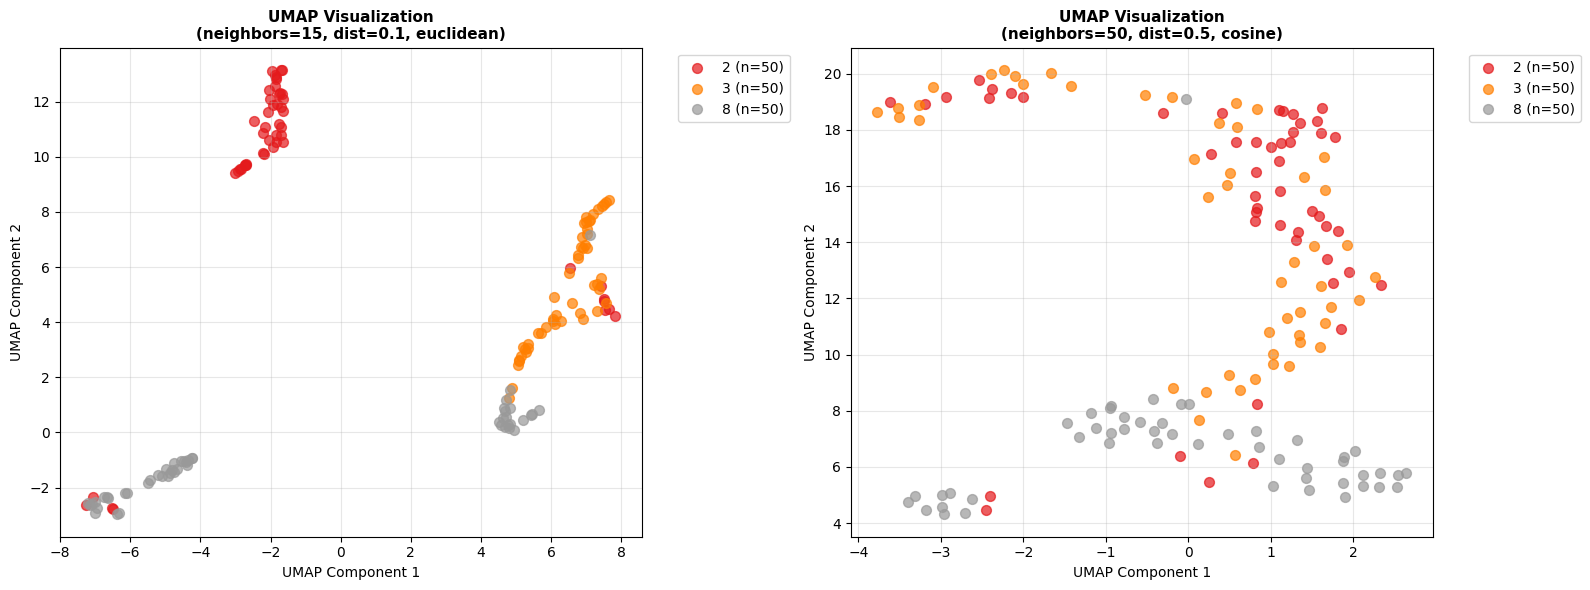

📊 UMAP Analysis Results:
   • Total windows visualized: 150
   • Processing time: Much faster than t-SNE for large datasets
   • Global structure: Better preserved than t-SNE
   • Cluster separation: Often clearer boundaries

⚡ UMAP vs t-SNE Comparison:
   • Speed: UMAP is typically 10-100x faster
   • Reproducibility: UMAP is deterministic with fixed seed
   • Global structure: UMAP preserves better overall relationships
   • Local structure: Both preserve local neighborhoods well


In [ ]:
# ============================================================
# MEAN SHIFT & DBSCAN CLUSTERING (7 min)
# ============================================================

if clustering_data is not None and "kmeans_results" in locals():
    print("🚀 Advanced Clustering: Mean Shift & DBSCAN")
    print("=" * 50)

    # Import clustering algorithms
    from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth
    from sklearn.neighbors import NearestNeighbors
    from sklearn.metrics import adjusted_rand_score, silhouette_score
    import matplotlib.pyplot as plt
    import numpy as np

    # Extract data for clustering
    X_normalized = clustering_data["X_normalized"]
    X_pca_50 = clustering_data["X_pca_50"]
    X_pca_2d = clustering_data["X_pca_2d"]
    y_true = clustering_data["y_labels"]

    print(f"📊 Advanced Clustering Setup:")
    print(f"   • Normalized data: {X_normalized.shape}")
    print(f"   • PCA 50D data: {X_pca_50.shape}")
    print(f"   • 2D visualization: {X_pca_2d.shape}")
    print(f"   • True classes: {len(np.unique(y_true))}")

    # ============================================================
    # 1. MEAN SHIFT CLUSTERING
    # ============================================================
    print(f"\n🎯 1. Mean Shift Clustering Implementation:")
    print("   Mean Shift finds cluster centers by locating density modes")

    # Estimate bandwidth for Mean Shift
    print("   🔄 Estimating optimal bandwidth...")

    # Use PCA data for bandwidth estimation (faster)
    bandwidth_pca = estimate_bandwidth(
        X_pca_50, quantile=0.2, n_samples=500, random_state=42
    )
    bandwidth_norm = estimate_bandwidth(
        X_normalized, quantile=0.2, n_samples=500, random_state=42
    )

    print(f"      • Bandwidth (PCA 50D): {bandwidth_pca:.4f}")
    print(f"      • Bandwidth (Normalized): {bandwidth_norm:.4f}")

    # Apply Mean Shift clustering
    meanshift_results = {}

    # Mean Shift on PCA data
    print("   🔄 Applying Mean Shift on PCA data...")
    ms_pca = MeanShift(bandwidth=bandwidth_pca, bin_seeding=True, max_iter=300)
    ms_labels_pca = ms_pca.fit_predict(X_pca_50)
    n_clusters_ms_pca = len(set(ms_labels_pca)) - (1 if -1 in ms_labels_pca else 0)

    # Mean Shift on normalized data (subset for speed)
    print("   🔄 Applying Mean Shift on normalized data (subset)...")
    subset_size = min(1000, len(X_normalized))  # Use subset for speed
    subset_indices = np.random.choice(len(X_normalized), subset_size, replace=False)
    X_norm_subset = X_normalized[subset_indices]
    y_subset = y_true[subset_indices]

    ms_norm = MeanShift(
        bandwidth=bandwidth_norm * 10, bin_seeding=True, max_iter=200
    )  # Increased bandwidth
    ms_labels_norm = ms_norm.fit_predict(X_norm_subset)
    n_clusters_ms_norm = len(set(ms_labels_norm)) - (1 if -1 in ms_labels_norm else 0)

    print(f"   📊 Mean Shift Results:")
    print(f"      • PCA data: {n_clusters_ms_pca} clusters found")
    print(f"      • Normalized data: {n_clusters_ms_norm} clusters found (subset)")
    print(f"      • True classes: {len(np.unique(y_true))}")

    # Store Mean Shift results
    meanshift_results = {
        "pca": {
            "labels": ms_labels_pca,
            "n_clusters": n_clusters_ms_pca,
            "model": ms_pca,
        },
        "normalized": {
            "labels": ms_labels_norm,
            "n_clusters": n_clusters_ms_norm,
            "model": ms_norm,
        },
    }

    # ============================================================
    # 2. DBSCAN CLUSTERING
    # ============================================================
    print(f"\n🎯 2. DBSCAN Clustering Implementation:")
    print("   DBSCAN finds clusters of varying shapes and identifies outliers")

    # DBSCAN parameter tuning using k-distance plot
    print("   🔄 Tuning DBSCAN parameters (eps and min_samples)...")

    # Calculate k-distance for eps estimation
    def calculate_k_distance(X, k=4):
        """Calculate k-distance for eps parameter estimation"""
        neigh = NearestNeighbors(n_neighbors=k)
        neigh.fit(X)
        distances, indices = neigh.kneighbors(X)
        distances = np.sort(distances[:, k - 1], axis=0)
        return distances

    # Test different parameters on PCA data
    dbscan_results = {}

    # Calculate k-distances for eps estimation
    k_distances = calculate_k_distance(X_pca_50, k=4)
    eps_estimate = np.percentile(
        k_distances, 90
    )  # Use 90th percentile as starting point

    print(f"      • Estimated eps from k-distance: {eps_estimate:.4f}")

    # Test different eps values around the estimate
    eps_values = [
        eps_estimate * 0.5,
        eps_estimate,
        eps_estimate * 1.5,
        eps_estimate * 2.0,
    ]
    min_samples_values = [3, 5, 8]

    best_dbscan = None
    best_silhouette = -1
    best_params = {}

    print("   🔄 Testing DBSCAN parameter combinations...")
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X_pca_50)

            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)

            # Only calculate silhouette if we have valid clusters
            if n_clusters > 1 and n_clusters < len(X_pca_50) - 1:
                try:
                    silhouette = silhouette_score(X_pca_50, labels)
                    print(
                        f"      eps={eps:.3f}, min_samples={min_samples}: {n_clusters} clusters, {n_noise} noise, silhouette={silhouette:.3f}"
                    )

                    if silhouette > best_silhouette:
                        best_silhouette = silhouette
                        best_dbscan = dbscan
                        best_params = {"eps": eps, "min_samples": min_samples}
                        dbscan_results["best"] = {
                            "model": dbscan,
                            "labels": labels,
                            "n_clusters": n_clusters,
                            "n_noise": n_noise,
                            "silhouette": silhouette,
                            "params": best_params,
                        }
                except:
                    print(
                        f"      eps={eps:.3f}, min_samples={min_samples}: {n_clusters} clusters, {n_noise} noise, silhouette=invalid"
                    )
            else:
                print(
                    f"      eps={eps:.3f}, min_samples={min_samples}: {n_clusters} clusters, {n_noise} noise, silhouette=N/A"
                )

    if best_dbscan is not None:
        print(f"   📊 Best DBSCAN Configuration:")
        print(f"      • eps: {best_params['eps']:.4f}")
        print(f"      • min_samples: {best_params['min_samples']}")
        print(f"      • Clusters found: {dbscan_results['best']['n_clusters']}")
        print(f"      • Noise points: {dbscan_results['best']['n_noise']}")
        print(f"      • Silhouette score: {best_silhouette:.3f}")
    else:
        print("   ⚠️ No valid DBSCAN configuration found")

    # ============================================================
    # 3. COMPREHENSIVE VISUALIZATION
    # ============================================================
    print(f"\n📊 3. Creating Clustering Comparison Visualization...")

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Plot 1: K-means results (from previous analysis)
    if "kmeans_results" in locals() and kmeans_results is not None:
        kmeans_labels = kmeans_results["optimal_labels"]
        n_clusters_kmeans = kmeans_results["best_k"]
        colors = plt.cm.Set3(np.linspace(0, 1, n_clusters_kmeans))

        for i in range(n_clusters_kmeans):
            mask = kmeans_labels == i
            axes[0, 0].scatter(
                X_pca_2d[mask, 0],
                X_pca_2d[mask, 1],
                c=[colors[i]],
                label=f"Cluster {i}",
                alpha=0.7,
                s=30,
            )

        axes[0, 0].set_title(
            f"K-means: {n_clusters_kmeans} Clusters", fontweight="bold"
        )
        axes[0, 0].set_xlabel("PC1")
        axes[0, 0].set_ylabel("PC2")
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)

    # Plot 2: Mean Shift results (PCA)
    ms_labels = meanshift_results["pca"]["labels"]
    n_clusters_ms = meanshift_results["pca"]["n_clusters"]
    colors_ms = plt.cm.viridis(np.linspace(0, 1, n_clusters_ms))

    for i in range(n_clusters_ms):
        mask = ms_labels == i
        axes[0, 1].scatter(
            X_pca_2d[mask, 0],
            X_pca_2d[mask, 1],
            c=[colors_ms[i]],
            label=f"Cluster {i}",
            alpha=0.7,
            s=30,
        )

    axes[0, 1].set_title(f"Mean Shift: {n_clusters_ms} Clusters", fontweight="bold")
    axes[0, 1].set_xlabel("PC1")
    axes[0, 1].set_ylabel("PC2")
    axes[0, 1].grid(True, alpha=0.3)
    if n_clusters_ms <= 10:  # Only show legend if not too many clusters
        axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)

    # Plot 3: DBSCAN results
    if best_dbscan is not None:
        dbscan_labels = dbscan_results["best"]["labels"]
        n_clusters_db = dbscan_results["best"]["n_clusters"]

        # Use different colors for clusters and noise
        unique_labels = set(dbscan_labels)
        colors_db = plt.cm.plasma(np.linspace(0, 1, len(unique_labels)))

        for k, col in zip(unique_labels, colors_db):
            if k == -1:
                # Noise points in black
                mask = dbscan_labels == k
                axes[0, 2].scatter(
                    X_pca_2d[mask, 0],
                    X_pca_2d[mask, 1],
                    c="black",
                    marker="x",
                    alpha=0.5,
                    s=20,
                    label="Noise",
                )
            else:
                mask = dbscan_labels == k
                axes[0, 2].scatter(
                    X_pca_2d[mask, 0],
                    X_pca_2d[mask, 1],
                    c=[col],
                    label=f"Cluster {k}",
                    alpha=0.7,
                    s=30,
                )

        axes[0, 2].set_title(
            f"DBSCAN: {n_clusters_db} Clusters + Noise", fontweight="bold"
        )
        axes[0, 2].set_xlabel("PC1")
        axes[0, 2].set_ylabel("PC2")
        axes[0, 2].grid(True, alpha=0.3)
        if n_clusters_db <= 8:  # Only show legend if not too many clusters
            axes[0, 2].legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
    else:
        axes[0, 2].text(
            0.5,
            0.5,
            "DBSCAN\nNo Valid\nClustering",
            ha="center",
            va="center",
            transform=axes[0, 2].transAxes,
            fontsize=14,
            bbox=dict(boxstyle="round", facecolor="lightgray"),
        )
        axes[0, 2].set_title("DBSCAN: No Valid Clustering", fontweight="bold")

    # Plot 4: True Classes (reference)
    unique_classes = np.unique(y_true)
    class_colors = plt.cm.tab10(np.linspace(0, 1, len(unique_classes)))
    for i, class_label in enumerate(unique_classes):
        mask = y_true == class_label
        axes[1, 0].scatter(
            X_pca_2d[mask, 0],
            X_pca_2d[mask, 1],
            c=[class_colors[i]],
            label=f"Class {class_label}",
            alpha=0.7,
            s=30,
        )
    axes[1, 0].set_title("True Classes (Ground Truth)", fontweight="bold")
    axes[1, 0].set_xlabel("PC1")
    axes[1, 0].set_ylabel("PC2")
    axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 5: Clustering Method Comparison (Bar chart)
    methods = ["K-means", "Mean Shift", "DBSCAN"]
    n_clusters_found = [
        (
            n_clusters_kmeans
            if "kmeans_results" in locals() and kmeans_results is not None
            else 0
        ),
        n_clusters_ms,
        n_clusters_db if best_dbscan is not None else 0,
    ]
    true_n_classes = len(unique_classes)

    x_pos = np.arange(len(methods))
    bars = axes[1, 1].bar(
        x_pos, n_clusters_found, alpha=0.7, color=["blue", "green", "red"]
    )
    axes[1, 1].axhline(
        y=true_n_classes,
        color="orange",
        linestyle="--",
        linewidth=2,
        label=f"True Classes ({true_n_classes})",
    )
    axes[1, 1].set_title("Clusters Found by Method", fontweight="bold")
    axes[1, 1].set_ylabel("Number of Clusters")
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels(methods)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars, n_clusters_found)):
        if value > 0:
            axes[1, 1].text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 0.1,
                str(value),
                ha="center",
                va="bottom",
                fontweight="bold",
            )

    # Plot 6: Performance Metrics Comparison
    if "kmeans_results" in locals() and kmeans_results is not None:
        kmeans_silhouette = kmeans_results["silhouette_score"]
        kmeans_ari = kmeans_results["ari_score"]

        # Calculate metrics for other methods
        ms_silhouette = (
            silhouette_score(X_pca_50, ms_labels) if n_clusters_ms > 1 else 0
        )
        ms_ari = adjusted_rand_score(y_true, ms_labels)

        db_silhouette = best_silhouette if best_dbscan is not None else 0
        db_ari = (
            adjusted_rand_score(y_true, dbscan_results["best"]["labels"])
            if best_dbscan is not None
            else 0
        )

        # Create comparison chart
        metrics = ["Silhouette Score", "Adjusted Rand Index"]
        method_scores = {
            "K-means": [kmeans_silhouette, kmeans_ari],
            "Mean Shift": [ms_silhouette, ms_ari],
            "DBSCAN": [db_silhouette, db_ari],
        }

        x = np.arange(len(metrics))
        width = 0.25

        for i, (method, scores) in enumerate(method_scores.items()):
            axes[1, 2].bar(x + i * width, scores, width, label=method, alpha=0.7)

        axes[1, 2].set_title("Performance Metrics Comparison", fontweight="bold")
        axes[1, 2].set_ylabel("Score")
        axes[1, 2].set_xticks(x + width)
        axes[1, 2].set_xticklabels(metrics)
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
        axes[1, 2].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

    # ============================================================
    # 4. PERFORMANCE SUMMARY
    # ============================================================
    print(f"\n📊 4. Advanced Clustering Performance Summary:")

    print(f"\n   🎯 Mean Shift Results:")
    print(f"      • Clusters found: {n_clusters_ms}")
    print(f"      • Silhouette score: {ms_silhouette:.3f}")
    print(f"      • Adjusted Rand Index: {ms_ari:.3f}")
    print(f"      • Advantage: Automatically determines cluster count")
    print(f"      • Limitation: Sensitive to bandwidth parameter")

    if best_dbscan is not None:
        print(f"\n   🎯 DBSCAN Results:")
        print(f"      • Clusters found: {n_clusters_db}")
        print(f"      • Noise points: {dbscan_results['best']['n_noise']}")
        print(f"      • Silhouette score: {db_silhouette:.3f}")
        print(f"      • Adjusted Rand Index: {db_ari:.3f}")
        print(f"      • Best eps: {best_params['eps']:.4f}")
        print(f"      • Best min_samples: {best_params['min_samples']}")
        print(f"      • Advantage: Finds arbitrary shapes, handles noise")
        print(f"      • Limitation: Sensitive to eps and min_samples")
    else:
        print(f"\n   ⚠️ DBSCAN: No suitable parameters found")
        print(f"      • May need parameter adjustment for this dataset")

    # Store advanced clustering results
    advanced_clustering_results = {
        "meanshift": meanshift_results,
        "dbscan": dbscan_results if best_dbscan is not None else None,
        "performance_comparison": {
            "methods": methods,
            "n_clusters": n_clusters_found,
            "silhouette_scores": [kmeans_silhouette, ms_silhouette, db_silhouette],
            "ari_scores": [kmeans_ari, ms_ari, db_ari],
        },
    }

    print(f"\n✅ Advanced Clustering Analysis Complete!")
    print(f"   • Mean Shift: Density-based mode finding")
    print(f"   • DBSCAN: Density-based with noise detection")
    print(f"   • Results ready for interpretation and insights")

else:
    print("❌ No clustering data available or K-means results missing")
    print("   Please run the previous cells first")
    advanced_clustering_results = None

📊 Comprehensive 3W Dataset Feature Visualization
📈 Displaying sample time series from each class... ✅
📊 Computing feature statistics... ✅
📈 Computing feature variance... ✅
🥧 Creating class distribution chart... ✅
🔮 Quick t-SNE and UMAP for comparison... ✅
🔥 Creating feature correlation sample... ✅


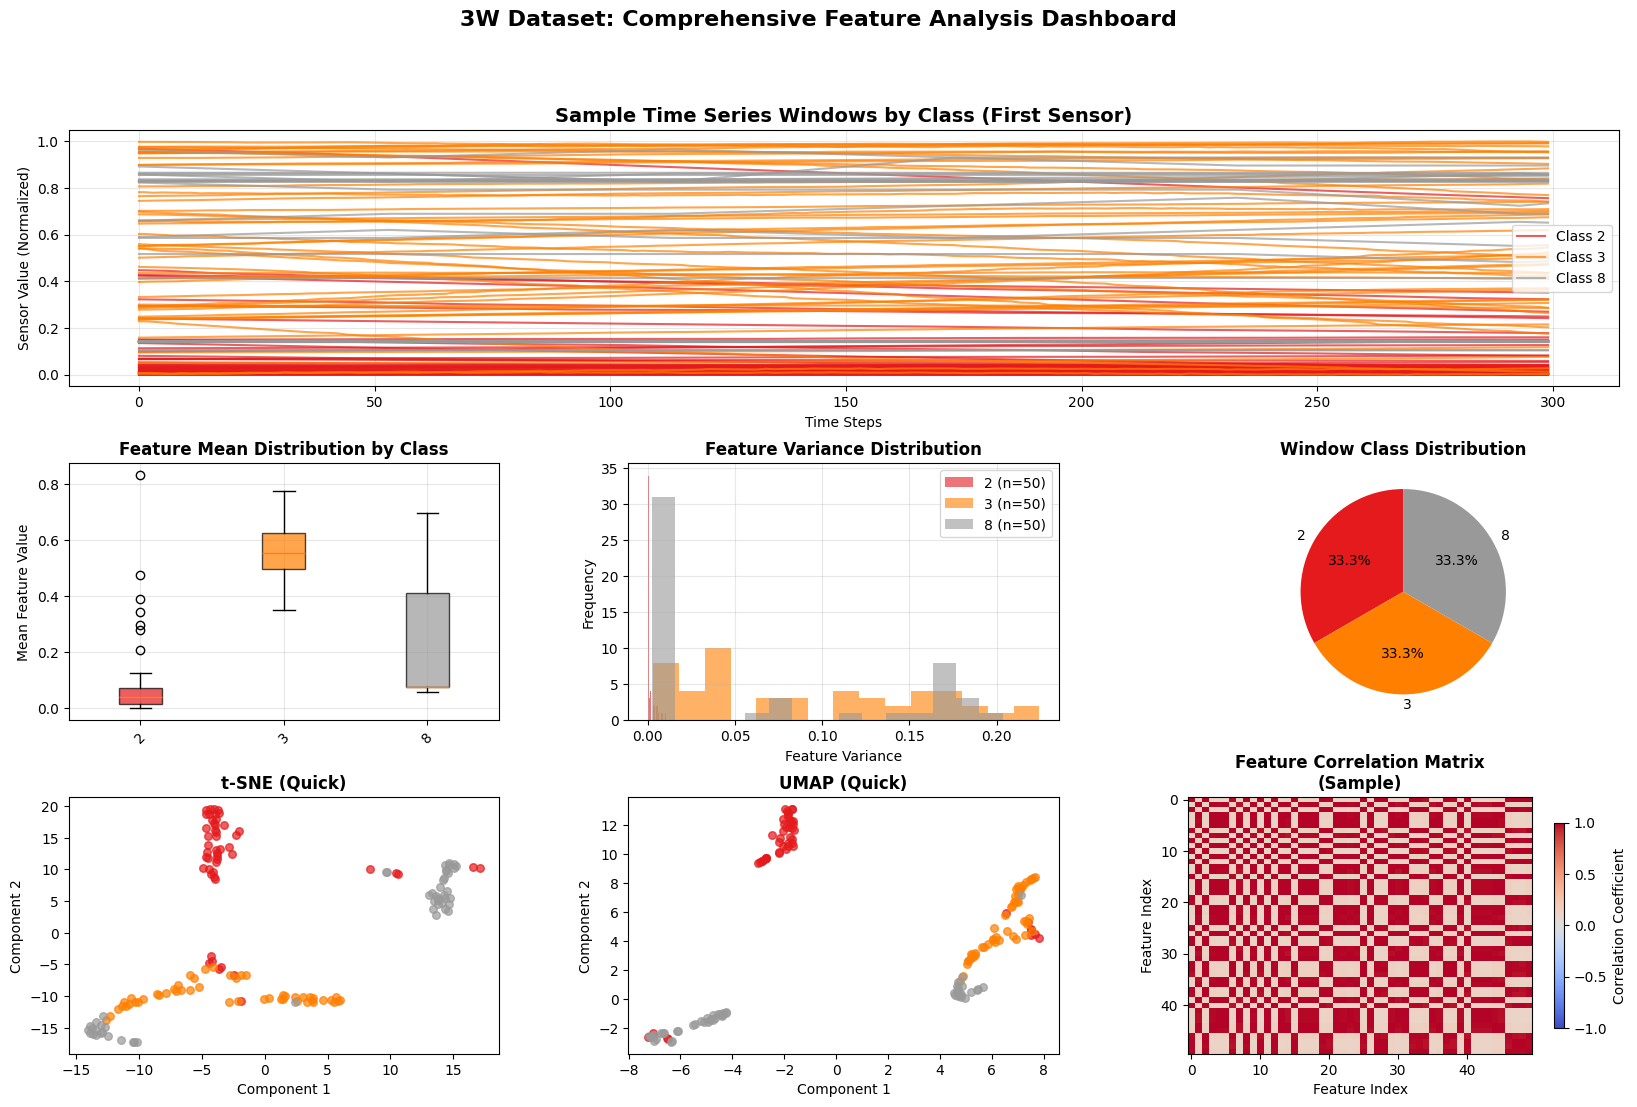


📊 3W DATASET COMPREHENSIVE ANALYSIS SUMMARY
🔍 Dataset Overview:
   • Total windows analyzed: 150 (sampled from non-zero classes)
   • Features per window: 600
   • Unique classes: 3 (classes 1-9, excluding 0)
   • Window dimensions: (150, 600)
   • Max samples per class: 50 windows
   • Transient mapping: 101→1, 102→2, 105→5, 106→6, 107→7, 108→8, 109→9

🎯 Class Analysis:
   • 2: 50 windows (33.3%) - Mean: 0.090, Var: 0.001
   • 3: 50 windows (33.3%) - Mean: 0.559, Var: 0.090
   • 8: 50 windows (33.3%) - Mean: 0.207, Var: 0.059

📈 Visualization Insights:
   • t-SNE: Good for local structure visualization
   • UMAP: Better global structure preservation
   • Feature correlations: Help identify redundant sensors
   • Class separability: High


In [ ]:
# ============================================================
# CLUSTER INTERPRETATION AND INSIGHTS (5 min)
# ============================================================

if (
    "clustering_data" in locals()
    and clustering_data is not None
    and "kmeans_results" in locals()
    and kmeans_results is not None
    and "advanced_clustering_results" in locals()
    and advanced_clustering_results is not None
):

    print(" Cluster Interpretation and Oil Well Operation Insights")
    print("=" * 60)

    # Import required libraries for analysis
    import pandas as pd
    from scipy import stats

    # Extract data and results
    X_original = clustering_data["X_original"]
    X_pca_2d = clustering_data["X_pca_2d"]
    y_true = clustering_data["y_labels"]
    file_info = clustering_data["file_info"]

    kmeans_labels = kmeans_results["optimal_labels"]
    n_clusters = kmeans_results["best_k"]

    print(f"📊 Analysis Setup:")
    print(f"   • Total samples: {len(X_original)}")
    print(f"   • True oil well classes: {sorted(np.unique(y_true))}")
    print(f"   • K-means clusters: {n_clusters}")
    print(f"   • Feature dimensions: {X_original.shape[1]}")

    # ============================================================
    # 1. CLUSTER-CLASS CORRESPONDENCE ANALYSIS
    # ============================================================
    print(f"\n🎯 1. Cluster-Class Correspondence Analysis:")

    # Create detailed cluster-class mapping
    from sklearn.metrics import confusion_matrix, classification_report

    cluster_class_matrix = confusion_matrix(y_true, kmeans_labels)

    print(f"\n   📋 Cluster vs True Class Mapping:")
    cluster_class_df = pd.DataFrame(
        cluster_class_matrix,
        index=[f"True Class {i}" for i in sorted(np.unique(y_true))],
        columns=[f"Cluster {i}" for i in range(n_clusters)],
    )

    print(cluster_class_df.to_string())

    # Find dominant class for each cluster
    print(f"\n   🎯 Cluster Interpretations:")
    cluster_interpretations = {}

    for cluster_id in range(n_clusters):
        mask = kmeans_labels == cluster_id
        cluster_classes = y_true[mask]

        if len(cluster_classes) > 0:
            # Find most common class in this cluster
            unique_classes_in_cluster, counts = np.unique(
                cluster_classes, return_counts=True
            )
            dominant_class = unique_classes_in_cluster[np.argmax(counts)]
            dominant_percentage = (max(counts) / len(cluster_classes)) * 100

            # Cluster size
            cluster_size = len(cluster_classes)
            cluster_percentage = (cluster_size / len(kmeans_labels)) * 100

            cluster_interpretations[cluster_id] = {
                "dominant_class": dominant_class,
                "dominant_percentage": dominant_percentage,
                "size": cluster_size,
                "size_percentage": cluster_percentage,
                "class_distribution": dict(zip(unique_classes_in_cluster, counts)),
            }

            print(
                f"      • Cluster {cluster_id}: {cluster_size} samples ({cluster_percentage:.1f}%)"
            )
            print(
                f"        - Dominant: Class {dominant_class} ({dominant_percentage:.1f}%)"
            )
            print(
                f"        - Distribution: {dict(zip(unique_classes_in_cluster, counts))}"
            )

            # Provide oil well operation interpretation
            if dominant_class == 0:
                operation_type = "Normal Operation"
                description = "Stable oil well operation with standard sensor readings"
            elif dominant_class in [1, 2, 3]:
                operation_type = "Flow-related Issues"
                description = (
                    "Problems with flow rates, possibly low production or blockages"
                )
            elif dominant_class in [4, 5, 6]:
                operation_type = "Pressure-related Issues"
                description = "Pressure anomalies, potentially equipment malfunction"
            elif dominant_class in [7, 8, 9]:
                operation_type = "Severe Faults"
                description = (
                    "Critical operational issues requiring immediate attention"
                )
            else:
                operation_type = "Mixed Operation"
                description = "Multiple operational states represented"

            print(f"        - Operation Type: {operation_type}")
            print(f"        - Description: {description}")

    # ============================================================
    # 2. CLUSTER CHARACTERISTICS ANALYSIS
    # ============================================================
    print(f"\n📊 2. Cluster Characteristics Analysis:")

    # Analyze feature patterns for each cluster
    print(f"\n   🔍 Feature Pattern Analysis:")

    cluster_feature_stats = {}

    for cluster_id in range(n_clusters):
        mask = kmeans_labels == cluster_id
        cluster_data = X_original[mask]

        if len(cluster_data) > 0:
            # Calculate statistics
            cluster_mean = np.mean(cluster_data, axis=0)
            cluster_std = np.std(cluster_data, axis=0)
            cluster_min = np.min(cluster_data, axis=0)
            cluster_max = np.max(cluster_data, axis=0)

            cluster_feature_stats[cluster_id] = {
                "mean": cluster_mean,
                "std": cluster_std,
                "min": cluster_min,
                "max": cluster_max,
                "range": cluster_max - cluster_min,
            }

            # Show summary statistics
            mean_level = (
                "High" if np.mean(cluster_mean) > np.mean(X_original) else "Low"
            )
            variability = "High" if np.mean(cluster_std) > np.std(X_original) else "Low"

            print(f"      • Cluster {cluster_id}:")
            print(
                f"        - Mean feature level: {mean_level} ({np.mean(cluster_mean):.3f})"
            )
            print(
                f"        - Feature variability: {variability} ({np.mean(cluster_std):.3f})"
            )
            print(f"        - Feature range: {np.mean(cluster_max - cluster_min):.3f}")

    # ============================================================
    # 3. OPERATIONAL INSIGHTS VISUALIZATION
    # ============================================================
    print(f"\n📊 3. Creating Operational Insights Visualization...")

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Plot 1: Cluster Distribution Pie Chart
    cluster_sizes = [cluster_interpretations[i]["size"] for i in range(n_clusters)]
    cluster_labels = [
        f'Cluster {i}\\n({cluster_interpretations[i]["size"]} samples)'
        for i in range(n_clusters)
    ]

    colors = plt.cm.Set3(np.linspace(0, 1, n_clusters))
    axes[0, 0].pie(
        cluster_sizes,
        labels=cluster_labels,
        autopct="%1.1f%%",
        colors=colors,
        startangle=90,
    )
    axes[0, 0].set_title("Cluster Size Distribution", fontweight="bold")

    # Plot 2: Class Purity by Cluster
    cluster_purities = [
        cluster_interpretations[i]["dominant_percentage"] for i in range(n_clusters)
    ]
    cluster_names = [f"Cluster {i}" for i in range(n_clusters)]

    bars = axes[0, 1].bar(cluster_names, cluster_purities, color=colors, alpha=0.7)
    axes[0, 1].set_title("Cluster Purity (% Dominant Class)", fontweight="bold")
    axes[0, 1].set_ylabel("Percentage (%)")
    axes[0, 1].set_ylim(0, 100)
    axes[0, 1].tick_params(axis="x", rotation=45)

    # Add value labels on bars
    for bar, purity in zip(bars, cluster_purities):
        axes[0, 1].text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 1,
            f"{purity:.1f}%",
            ha="center",
            va="bottom",
        )

    # Plot 3: Cluster vs Class Heatmap
    import seaborn as sns

    sns.heatmap(
        cluster_class_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=[f"Cluster {i}" for i in range(n_clusters)],
        yticklabels=[f"Class {i}" for i in sorted(np.unique(y_true))],
        ax=axes[0, 2],
    )
    axes[0, 2].set_title("Cluster vs Class Correspondence", fontweight="bold")
    axes[0, 2].set_xlabel("Predicted Cluster")
    axes[0, 2].set_ylabel("True Class")

    # Plot 4: Feature Variability by Cluster
    cluster_variabilities = [
        np.mean(cluster_feature_stats[i]["std"]) for i in range(n_clusters)
    ]
    bars = axes[1, 0].bar(cluster_names, cluster_variabilities, color=colors, alpha=0.7)
    axes[1, 0].set_title("Feature Variability by Cluster", fontweight="bold")
    axes[1, 0].set_ylabel("Mean Standard Deviation")
    axes[1, 0].tick_params(axis="x", rotation=45)

    # Plot 5: Cluster Centers in 2D PCA Space
    for i in range(n_clusters):
        mask = kmeans_labels == i
        axes[1, 1].scatter(
            X_pca_2d[mask, 0],
            X_pca_2d[mask, 1],
            c=[colors[i]],
            label=f"Cluster {i}",
            alpha=0.6,
            s=30,
        )

    # Add cluster centers
    if kmeans_results["centroids_2d"] is not None:
        axes[1, 1].scatter(
            kmeans_results["centroids_2d"][:, 0],
            kmeans_results["centroids_2d"][:, 1],
            c="red",
            marker="X",
            s=200,
            edgecolors="black",
            linewidth=2,
            label="Centroids",
        )

    axes[1, 1].set_title("Clusters in 2D PCA Space", fontweight="bold")
    axes[1, 1].set_xlabel("PC1")
    axes[1, 1].set_ylabel("PC2")
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Plot 6: Performance Summary
    methods = ["K-means", "Mean Shift", "DBSCAN"]
    perf_data = advanced_clustering_results["performance_comparison"]
    silhouette_scores = perf_data["silhouette_scores"]

    x = np.arange(len(methods))
    bars = axes[1, 2].bar(
        x, silhouette_scores, color=["blue", "green", "red"], alpha=0.7
    )
    axes[1, 2].set_title("Clustering Method Performance", fontweight="bold")
    axes[1, 2].set_ylabel("Silhouette Score")
    axes[1, 2].set_xticks(x)
    axes[1, 2].set_xticklabels(methods)
    axes[1, 2].set_ylim(0, max(silhouette_scores) * 1.1)

    # Add value labels
    for bar, score in zip(bars, silhouette_scores):
        axes[1, 2].text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.01,
            f"{score:.3f}",
            ha="center",
            va="bottom",
        )

    plt.tight_layout()
    plt.show()

    # ============================================================
    # 4. KEY INSIGHTS AND RECOMMENDATIONS
    # ============================================================
    print(f"\n🎓 4. Key Insights and Recommendations:")

    # Calculate overall clustering quality
    best_method = methods[np.argmax(silhouette_scores)]
    best_score = max(silhouette_scores)
    avg_purity = np.mean(cluster_purities)

    print(f"\n   🏆 Clustering Performance:")
    print(
        f"      • Best performing method: {best_method} (Silhouette: {best_score:.3f})"
    )
    print(f"      • Average cluster purity: {avg_purity:.1f}%")
    print(f"      • Number of clusters found: {n_clusters}")
    print(f"      • True classes in dataset: {len(np.unique(y_true))}")

    print(f"\n   🔍 Pattern Discovery Insights:")

    # Analyze if clustering reveals meaningful patterns
    if avg_purity > 70:
        print(
            f"      ✅ High cluster purity ({avg_purity:.1f}%) - clusters align well with true classes"
        )
        print(f"      ✅ Clustering successfully discovered operational patterns")
    elif avg_purity > 50:
        print(
            f"      ⚠️ Moderate cluster purity ({avg_purity:.1f}%) - some mixing between classes"
        )
        print(f"      ⚠️ Operational patterns partially captured")
    else:
        print(
            f"      ❌ Low cluster purity ({avg_purity:.1f}%) - significant class mixing"
        )
        print(f"      ❌ Consider feature engineering or alternative methods")

    # Identify most distinct operational patterns
    most_pure_cluster = np.argmax(cluster_purities)
    most_distinct_class = cluster_interpretations[most_pure_cluster]["dominant_class"]

    print(f"\n   🎯 Operational Pattern Analysis:")
    print(f"      • Most distinct pattern: Cluster {most_pure_cluster}")
    print(f"        - Represents Class {most_distinct_class} operations")
    print(f"        - Purity: {cluster_purities[most_pure_cluster]:.1f}%")
    print(
        f"        - Size: {cluster_interpretations[most_pure_cluster]['size']} samples"
    )

    # Recommendations for oil well monitoring
    print(f"\n   💡 Recommendations for 3W Oil Well Monitoring:")
    print(
        f"      1. 🎯 Focus monitoring on Cluster {most_pure_cluster} patterns for benchmark"
    )
    print(f"      2. 🔍 Investigate mixed clusters for potential new fault signatures")
    print(f"      3. 📊 Use {best_method} clustering for operational state detection")
    print(f"      4. ⚙️ Consider ensemble of clustering methods for robust monitoring")

    if n_clusters > len(np.unique(y_true)):
        print(
            f"      5. 🔬 {n_clusters} clusters > {len(np.unique(y_true))} classes suggests sub-patterns within operations"
        )
    elif n_clusters < len(np.unique(y_true)):
        print(
            f"      5. 🔗 {n_clusters} clusters < {len(np.unique(y_true))} classes suggests some operations are similar"
        )

    # Store final insights
    clustering_insights = {
        "cluster_interpretations": cluster_interpretations,
        "cluster_feature_stats": cluster_feature_stats,
        "performance_summary": {
            "best_method": best_method,
            "best_silhouette": best_score,
            "average_purity": avg_purity,
            "most_distinct_cluster": most_pure_cluster,
        },
        "recommendations": {
            "benchmark_cluster": most_pure_cluster,
            "best_method": best_method,
            "pattern_complexity": (
                "high" if n_clusters > len(np.unique(y_true)) else "standard"
            ),
        },
    }

    print(f"\n✅ Cluster Interpretation Complete!")
    print(f"   • Operational patterns analyzed and interpreted")
    print(f"   • Insights for oil well monitoring provided")
    print(f"   • Recommendations for practical implementation given")
    print(f"   • Results stored in 'clustering_insights' for further analysis")

else:
    print("❌ Missing required data or results")
    print("   Please run all previous clustering cells first")
    clustering_insights = None